<a href="https://colab.research.google.com/github/ShrutiPatel263/AI-Content-Quality-Virality-Analyzer/blob/main/RandomForest_LSTM_Stacked_Model_Optimized_FD004.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Pre Processing

In [ ]:
import numpy as np
import pandas as pd

from IPython.display import display, HTML
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio


import seaborn as sns
from importlib import reload
import matplotlib.pyplot as plt
import matplotlib
import warnings

# Configure Jupyter Notebook
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)
pd.set_option('display.expand_frame_repr', False)
# pd.set_option('max_colwidth', -1)
display(HTML("<style>div.output_scroll { height: 35em; }</style>"))

reload(plt)
%matplotlib inline
%config InlineBackend.figure_format ='retina'

warnings.filterwarnings('ignore')

# configure plotly graph objects
pio.renderers.default = 'iframe'
# pio.renderers.default = 'vscode'

pio.templates["ck_template"] = go.layout.Template(
    layout_colorway = px.colors.sequential.Viridis,
#     layout_hovermode = 'closest',
#     layout_hoverdistance = -1,
    layout_autosize=False,
    layout_width=800,
    layout_height=600,
    layout_font = dict(family="Calibri Light"),
    layout_title_font = dict(family="Calibri"),
    layout_hoverlabel_font = dict(family="Calibri Light"),
#     plot_bgcolor="white",
)

# pio.templates.default = 'seaborn+ck_template+gridon'
pio.templates.default = 'ck_template+gridon'
# pio.templates.default = 'seaborn+gridon'
# pio.templates

In [ ]:
index_names = ['engine', 'cycle']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names=[ "(Fan inlet temperature) (◦R)",
"(LPC outlet temperature) (◦R)",
"(HPC outlet temperature) (◦R)",
"(LPT outlet temperature) (◦R)",
"(Fan inlet Pressure) (psia)",
"(bypass-duct pressure) (psia)",
"(HPC outlet pressure) (psia)",
"(Physical fan speed) (rpm)",
"(Physical core speed) (rpm)",
"(Engine pressure ratio(P50/P2)",
"(HPC outlet Static pressure) (psia)",
"(Ratio of fuel flow to Ps30) (pps/psia)",
"(Corrected fan speed) (rpm)",
"(Corrected core speed) (rpm)",
"(Bypass Ratio) ",
"(Burner fuel-air ratio)",
"(Bleed Enthalpy)",
"(Required fan speed)",
"(Required fan conversion speed)",
"(High-pressure turbines Cool air flow)",
"(Low-pressure turbines Cool air flow)" ]
col_names = index_names + setting_names + sensor_names

In [ ]:
df_train = pd.read_csv('drive/MyDrive/archive/CMaps/train_FD004.txt',sep=r'\s+',header=None,index_col=False,names=col_names)
df_test = pd.read_csv('drive/MyDrive/archive/CMaps/test_FD004.txt',sep=r'\s+',header=None,index_col=False,names=col_names)
df_test_RUL = pd.read_csv('drive/MyDrive/archive/CMaps/RUL_FD004.txt',sep=r'\s+',header=None,index_col=False,names=['RUL'])

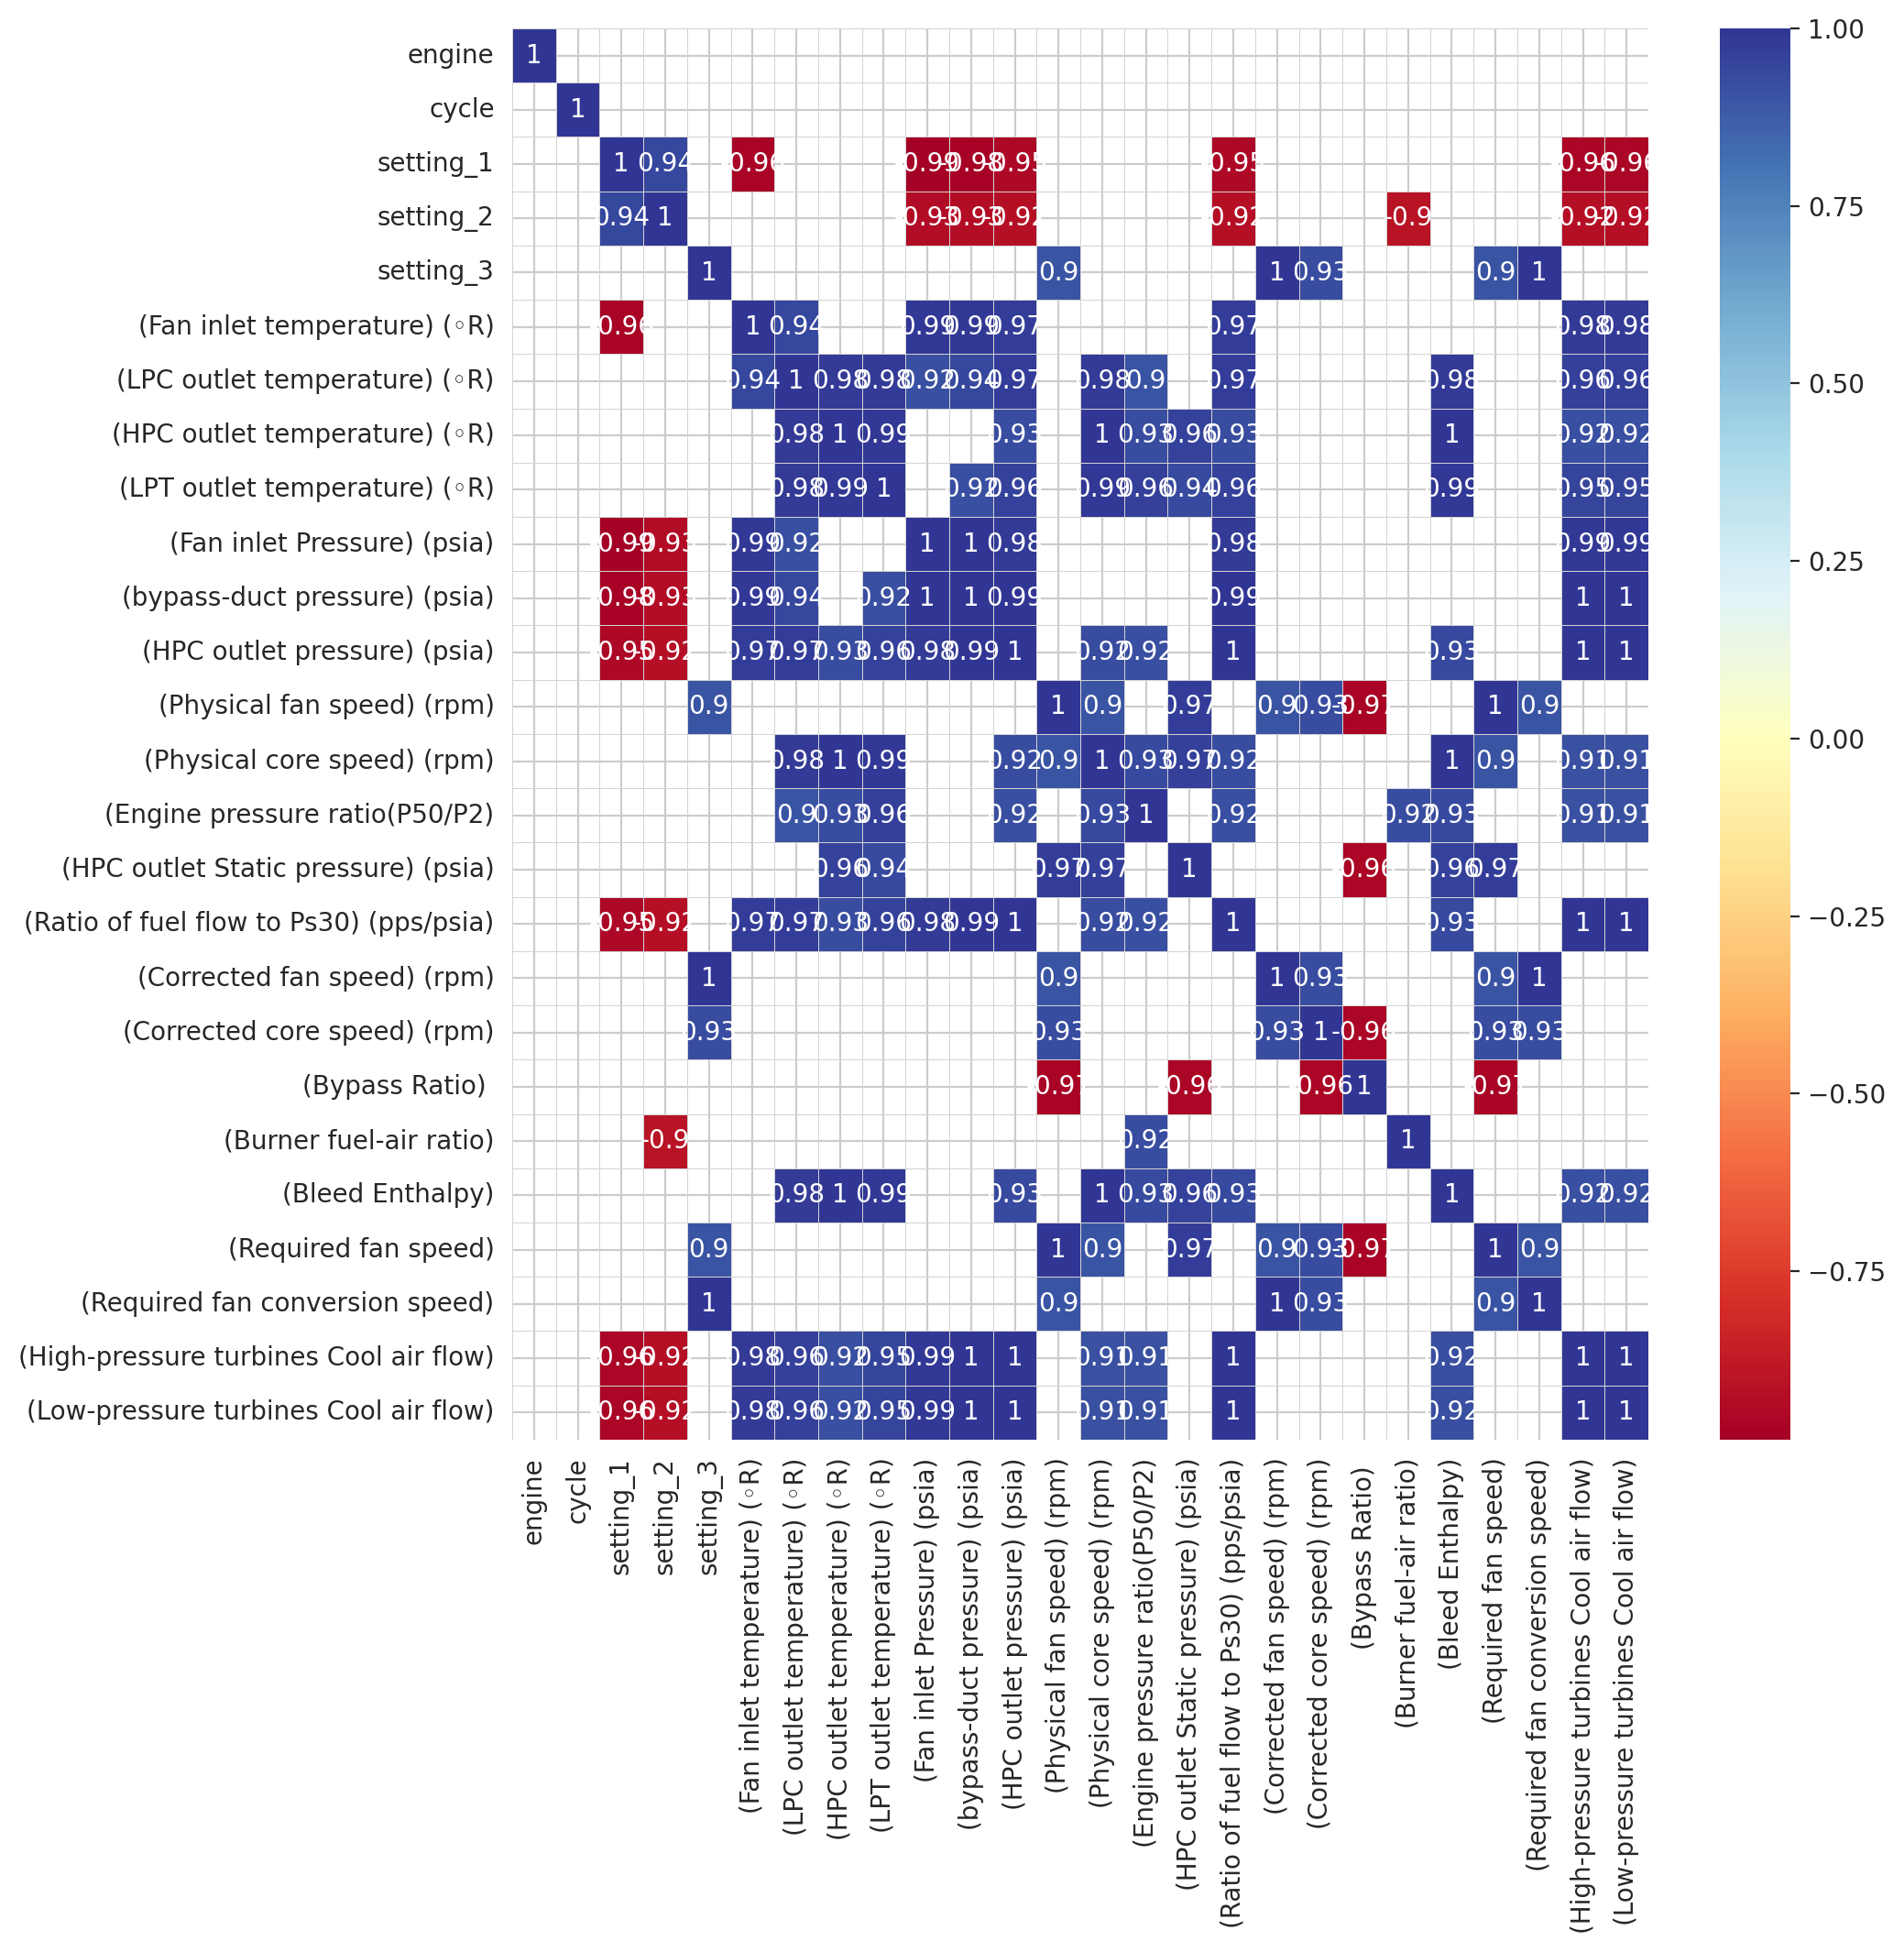

In [ ]:
plt.figure(figsize=(10,10))
threshold = 0.90
sns.set_style("whitegrid", {"axes.facecolor": ".0"})
df_cluster2 = df_train.corr()
mask = df_cluster2.where((abs(df_cluster2) >= threshold)).isna()
plot_kws={"s": 1}
sns.heatmap(df_cluster2,
            cmap='RdYlBu',
            annot=True,
            mask=mask,
            linewidths=0.2,
            linecolor='lightgrey').set_facecolor('white')

In [ ]:
sens_const_values = []
for feature in list(setting_names + sensor_names):
    try:
        if df_train[feature].min()==df_train[feature].max():
            sens_const_values.append(feature)
    except:
        pass

print(sens_const_values)
df_train.drop(sens_const_values,axis=1,inplace=True)
df_test.drop(sens_const_values,axis=1,inplace=True)

[]


In [ ]:
cor_matrix = df_train.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
corr_features = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print(corr_features)
df_train.drop(corr_features,axis=1,inplace=True)
df_test.drop(corr_features,axis=1,inplace=True)

['(Fan inlet temperature) (◦R)', '(HPC outlet temperature) (◦R)', '(LPT outlet temperature) (◦R)', '(Fan inlet Pressure) (psia)', '(bypass-duct pressure) (psia)', '(HPC outlet pressure) (psia)', '(Physical core speed) (rpm)', '(Engine pressure ratio(P50/P2)', '(HPC outlet Static pressure) (psia)', '(Ratio of fuel flow to Ps30) (pps/psia)', '(Corrected fan speed) (rpm)', '(Bypass Ratio) ', '(Bleed Enthalpy)', '(Required fan speed)', '(Required fan conversion speed)', '(High-pressure turbines Cool air flow)', '(Low-pressure turbines Cool air flow)']


In [ ]:
features = list(df_train.columns)

In [ ]:
# check for missing data
for feature in features:
    print(feature + " - " + str(len(df_train[df_train[feature].isna()])))

engine - 0
cycle - 0
setting_1 - 0
setting_2 - 0
setting_3 - 0
(LPC outlet temperature) (◦R) - 0
(Physical fan speed) (rpm) - 0
(Corrected core speed) (rpm) - 0
(Burner fuel-air ratio) - 0


In [ ]:
# define the maximum life of each engine, as this could be used to obtain the RUL at each point in time of the engine's life
df_train_RUL = df_train.groupby(['engine']).agg({'cycle':'max'})
df_train_RUL.rename(columns={'cycle':'life'},inplace=True)
df_train_RUL.head()

,life
engine,
1,321
2,299
3,307
4,274
5,193


In [ ]:
df_train=df_train.merge(df_train_RUL,how='left',on=['engine'])

In [ ]:
df_train['RUL']=df_train['life']-df_train['cycle']
df_train.drop(['life'],axis=1,inplace=True)

# the RUL prediction is only useful nearer to the end of the engine's life, therefore we put an upper limit on the RUL
# this is a bit sneaky, since it supposes that the test set has RULs of less than this value, the closer you are
# to the true value, the more accurate the model will be
df_train['RUL'][df_train['RUL']>125]=125
df_train.head()

,engine,cycle,setting_1,setting_2,setting_3,(LPC outlet temperature) (◦R),(Physical fan speed) (rpm),(Corrected core speed) (rpm),(Burner fuel-air ratio),RUL
0,1,1,42.0049,0.8400,100.0,549.68,2211.86,8074.83,0.02,125
1,1,2,20.0020,0.7002,100.0,606.07,2323.66,8046.13,0.02,125
2,1,3,42.0038,0.8409,100.0,548.95,2211.92,8066.62,0.02,125
3,1,4,42.0000,0.8400,100.0,548.70,2211.88,8076.05,0.02,125
4,1,5,25.0063,0.6207,60.0,536.10,1915.22,7865.80,0.02,125


In [ ]:
from scipy import signal
def smooth_function(x,window=15,order=3):
    return signal.savgol_filter(x,window,order)

In [ ]:
# awesome bit of code from https://www.kaggle.com/code/adibouayjan/house-price-step-by-step-modeling

Selected_Features = []
import statsmodels.api as sm

def backward_regression(X, y, initial_list=[], threshold_out=0.05, verbose=True):
    """To select feature with Backward Stepwise Regression

    Args:
        X -- features values
        y -- target variable
        initial_list -- features header
        threshold_out -- pvalue threshold of features to drop
        verbose -- true to produce lots of logging output

    Returns:
        list of selected features for modeling
    """
    included = list(X.columns)
    while True:
        changed = False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()  # null if pvalues is empty
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(f"worst_feature : {worst_feature}, {worst_pval} ")
        if not changed:
            break
    Selected_Features.append(included)
    print(f"\nSelected Features:\n{Selected_Features[0]}")


# Application of the backward regression function on our training data
X = df_train.iloc[:,1:-1]
y = df_train.iloc[:,-1]
backward_regression(X, y)


Selected Features:
['cycle', 'setting_1', 'setting_2', 'setting_3', '(LPC outlet temperature) (◦R)', '(Physical fan speed) (rpm)', '(Corrected core speed) (rpm)', '(Burner fuel-air ratio)']


In [ ]:
Selected_Features

[['cycle',
  'setting_1',
  'setting_2',
  'setting_3',
  '(LPC outlet temperature) (◦R)',
  '(Physical fan speed) (rpm)',
  '(Corrected core speed) (rpm)',
  '(Burner fuel-air ratio)']]

In [ ]:
# X.head()
feature_names = Selected_Features[0]
np.shape(X)

(61249, 8)

In [ ]:
import time
model_performance = pd.DataFrame(columns=['r-Squared','RMSE','total time'])

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer, accuracy_score

import sklearn
from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.ensemble import RandomForestRegressor

model_performance = pd.DataFrame(columns=['R2','RMSE', 'time to train','time to predict','total time'])


def R_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res/(SS_tot + K.epsilon())

In [ ]:
df_test_cycle = df_test.groupby(['engine']).agg({'cycle':'max'})
df_test_cycle.rename(columns={'cycle':'life'},inplace=True)
df_test_max = df_test.merge(df_test_cycle,how='left',on=['engine'])
df_test_max = df_test_max[(df_test_max['cycle']==df_test_max['life'])]
df_test_max.drop(['life'],axis=1,inplace=True)
# df_test_max

In [ ]:
X_train = df_train[feature_names]
y_train = df_train.iloc[:,-1]
X_test = df_test_max[feature_names]
y_test = df_test_RUL.iloc[:,-1]

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# XGBoost–LSTM Stacked Ensemble Model

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
rf = RandomForestRegressor(
    random_state=42,
    n_jobs=-1
)

In [ ]:
rf_param_grid = {
    'n_estimators': [200, 400, 600],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

In [ ]:
rf_search = RandomizedSearchCV(
    rf,
    rf_param_grid,
    n_iter=20,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

rf_search.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20, 30],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [ ]:
rf_best = rf_search.best_estimator_

In [ ]:
rf_train_pred = rf_best.predict(X_train)
rf_test_pred = rf_best.predict(X_test)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
X_train_lstm = X_train_scaled.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_lstm = X_test_scaled.reshape(X_test.shape[0], 1, X_test.shape[1])

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout
!pip install keras-tuner
import keras_tuner as kt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 3.2 MB/s eta 0:00:00


In [ ]:
def build_lstm_model(hp):
    model = tf.keras.Sequential()

    model.add(
        LSTM(
            units=hp.Int('lstm_units', 32, 128, step=32),
            input_shape=(1, X_train.shape[1])
        )
    )

    model.add(
        Dropout(hp.Float('dropout', 0.2, 0.5, step=0.1))
    )

    model.add(
        Dense(
            units=hp.Int('dense_units', 16, 64, step=16),
            activation='relu'
        )
    )

    model.add(Dense(1))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice('lr', [1e-2, 1e-3, 1e-4])
        ),
        loss='mse'
    )

    return model

In [ ]:
tuner = kt.RandomSearch(
    build_lstm_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='lstm_tuning',
    project_name='rul_lstm'
)

tuner.search(
    X_train_lstm,
    y_train,
    epochs=30,
    batch_size=500,
    validation_split=0.1,
    verbose=1
)

Trial 10 Complete [00h 00m 55s]
val_loss: 890.605712890625

Best val_loss So Far: 712.110107421875
Total elapsed time: 00h 09m 17s


In [ ]:
lstm_best = tuner.get_best_models(num_models=1)[0]

In [ ]:
lstm_train_pred = lstm_best.predict(X_train_lstm).ravel()
lstm_test_pred = lstm_best.predict(X_test_lstm).ravel()

1915/1915 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [ ]:
import numpy as np

meta_X_train = np.column_stack((rf_train_pred, lstm_train_pred))
meta_X_test = np.column_stack((rf_test_pred, lstm_test_pred))

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

ridge = Ridge()

ridge_params = {
    'alpha': [0.01, 0.1, 1.0, 10.0]
}

ridge_search = GridSearchCV(
    ridge,
    ridge_params,
    scoring='neg_root_mean_squared_error',
    cv=3
)

ridge_search.fit(meta_X_train, y_train)

GridSearchCV(cv=3, estimator=Ridge(),
             param_grid={'alpha': [0.01, 0.1, 1.0, 10.0]},
             scoring='neg_root_mean_squared_error')

In [ ]:
meta_best = ridge_search.best_estimator_

In [ ]:
final_predictions = meta_best.predict(meta_X_test)

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error

print("R2 Score:", r2_score(y_test, final_predictions))
print("RMSE:", np.sqrt(mean_squared_error(y_test, final_predictions)))

R2 Score: 0.6483820941508189
RMSE: 32.33117985754152
